**Reference:** [Integrated Decision Gradients](https://arxiv.org/abs/2305.20052)


# Imports


In [1]:
import hashlib
import os
import re
import jax
import GPUtil
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import jax.numpy as jnp
import seaborn as sns

from copy import deepcopy
from pathlib import Path
from scipy.stats import spearmanr, pearsonr
from colabfold.batch import get_queries, run, set_model_type
from colabfold.colabfold import plot_protein
from colabfold.download import download_alphafold_params
from colabfold.plot import plot_msa_v2
from colabfold.utils import setup_logging
from tqdm.auto import tqdm

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = f"{GPUtil.getFirstAvailable(order='memory', attempts=5, interval=30)[0]}"

# Configuration


- Taken directly from the [Colabfold Notebook](https://github.com/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb)


## Input Settings


- B1 domain of Protein G according to [UniProt](https://www.rcsb.org/sequence/3GB1#A):
  > TYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE
- Protein G according to [UniProt](https://www.uniprot.org/uniprotkb/P06654/entry):
  > VDSPIEDTPIIRNGGELTNLLGNSETTLALRNEESATADLTAAAVADTVAAAAAENAGAAAWEAAAAADALAKAKADALKEFNKYGVSDYYKNLINNAKTVEGIKDLQAQVVESAKKARISEATDGLSDFLKSQTPAEDTVKSIELAEAKVLANRELDKYGVSDYHKNLINNAKTVEGVKELIDEILAALPKTDTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTEKPEVIDASELTPAVTTYKLVINGKTLKGETTTKAVDAETAEKAFKQYANDNGVDGVWTYDDATKTFTVTEMVTEVPGDAPTEPEKPEASIPLVPLTPATPIAKDDAKKDDTKKEDAKKPEAKKDDAKKAETLPTT
- Tendamistat according to [UniProt](https://www.rcsb.org/sequence/1OK0):
  > DTTVSEPAPSCVTLYQSWRYSQADNGCAQTVTVKVVYEDDTEGLCYAVAPGQITTVGDGYIGSHGHARYLARCL
- Sso10a from Sulfolobus solfataricus according to [UniProt](https://www.rcsb.org/sequence/1R7J)
  > MAKKKSKLEIIQAILEACKSGSPKTRIMYGANLSYALTGRYIKMLMDLEIIRQEGKQYMLTKKGEELLEDIRKFNEMRKNMDQLKEKINSVLSIRQ
- Hylin-a1 according to [UniProt](https://www.uniprot.org/uniprotkb/P85982/entry)
  > IFGAILPLALGALKNLIK
- Conantokin-T (Con-T) according to [UniProt](https://www.uniprot.org/uniprotkb/P17684/entry)
  > GEEEYQKMLENLREAEVKKNA
- Humanin (Humanin mitochondrial) (HNM) according to [UniProt](https://www.uniprot.org/uniprotkb/Q8IVG9/entry)
  > MAPRGFSCLLLLTSEIDLPVKRRA
- CMTI-I(TrypsinInhibitor1) according to [UniProt](https://www.uniprot.org/uniprotkb/P01074/entry)
  > RVCPRILMECKKDSDCLAECVCLEHGYCG
- Alpha-conotoxin RgIA according to [UniProt](https://www.uniprot.org/uniprotkb/P0C1D0/entry)
  > GCCSDPRCRYRCR
- PP according to [UniProt](https://www.uniprot.org/uniprotkb/P68249/entry)
  > GPSQPTYPGDDAPVEDLIRFYNDLQQYLNVVTRHRY
- EAFP2 according to [UniProt](https://www.uniprot.org/uniprotkb/P83597/entry)
  > QTCASRCPRPCNAGLCCSIYGYCGSGAAYCGAGNCRCQCRG
- Ferredoxin according to [UniProt](https://www.uniprot.org/uniprotkb/P00198/entry)
  > MAYVINEACISCGACEPECPVNAISSGDDRYVIDADTCIDCGACAGVCPVDAPVQA


In [3]:
# Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer
query_sequence = "MAKKKSKLEIIQAILEACKSGSPKTRIMYGANLSYALTGRYIKMLMDLEIIRQEGKQYMLTKKGEELLEDIRKFNEMRKNMDQLKEKINSVLSIRQ"

protein_name = "Sso10a"
# Name of the experiment
jobname = f"IDG_{protein_name}"

# Specify how many of the top ranked structures to relax using amber
num_relax = 0  # possible values - [0, 1, 5]

# Whether to use pdb100 templates or not
use_templates = False

# whether to use amber relaxation or not
use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

In [4]:
def add_hash(x, y):
    return x + "_" + hashlib.sha1(y.encode()).hexdigest()[:5]


basejobname = "".join(jobname.split())
basejobname = re.sub(r"\W+", "", basejobname)
jobname = add_hash(basejobname, query_sequence)

In [5]:
# check if directory with jobname exists
def check(folder):
    if os.path.exists(folder):
        return False
    else:
        return True


if not check(jobname):
    n = 0
    while not check(f"{jobname}_{n}"):
        n += 1
    jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
    text_file.write(f"id,sequence\n{jobname},{query_sequence}")

In [6]:
print("jobname", jobname)
print("sequence", query_sequence)
print("length", len(query_sequence.replace(":", "")))

jobname IDG_Sso10a_24b59
sequence MAKKKSKLEIIQAILEACKSGSPKTRIMYGANLSYALTGRYIKMLMDLEIIRQEGKQYMLTKKGEELLEDIRKFNEMRKNMDQLKEKINSVLSIRQ
length 96


In [7]:
# MSA options - [single sequence, pairing mode]
# possible values - ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence"]
msa_mode = "mmseqs2_uniref_env"

# "unpaired_paired" = pair sequences from same species + unpaired MSA,
# "unpaired" = seperate MSA for each chain,
# "paired" - only use paired sequences.
# possible values - ["unpaired_paired","paired","unpaired"] {type:"string"}
pair_mode = "unpaired_paired"


# decide which a3m to use
if "mmseqs2" in msa_mode:
    a3m_file = os.path.join(jobname, f"{jobname}.a3m")
else:
    a3m_file = os.path.join(jobname, f"{jobname}.single_sequence.a3m")
    with open(a3m_file, "w") as text_file:
        text_file.write(">1\n%s" % query_sequence)

## Advanced Settings


In [8]:
# possible values -
#     ["auto", "alphafold2_ptm", "alphafold2_multimer_v1",
#     "alphafold2_multimer_v2", "alphafold2_multimer_v3", "deepfold_v1"]
#
# If `auto` is selected, will use `alphafold2_ptm` for monomer prediction and
# `alphafold2_multimer_v3` for complex prediction.
# Any of the mode_types can be used (regardless if input is monomer or complex).
model_type = "auto"

# possible values - ["auto", "0", "1", "3", "6", "12", "24", "48"]
# If `auto` selected, will use `num_recycles=20` if
# `model_type=alphafold2_multimer_v3`, else `num_recycles=3` .
num_recycles = "3"

# possible values - ["auto", "0.0", "0.5", "1.0"]
# If `auto` is selected, will use `tol=0.5`
# if `model_type=alphafold2_multimer_v3` else `tol=0.0`.
recycle_early_stop_tolerance = "auto"

# possible values - [0, 200, 2000]
# Max amber relaxation iterations, `0` = unlimited (default, takes very long)
relax_max_iterations = 200

# possible values - ["greedy", "complete"]
# `greedy` = pair any taxonomically matching subsets,
# `complete` = all sequences have to match in one line.
pairing_strategy = "greedy"

In [9]:
# process config
num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = (
    None
    if recycle_early_stop_tolerance == "auto"
    else float(recycle_early_stop_tolerance)
)

## Sampling settings


In [10]:
# Decrease `max_msa` to increase uncertainity
# possible values - ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
max_msa = "auto"

# Increase number of seeds to sample predictions from uncertainty of the model
# possible values - [1,2,4,8,16]
num_seeds = 1

# Whether to enable or disable dropouts
use_dropout = False

In [11]:
# process config
if max_msa == "auto":
    max_msa = None

## Save settings


In [12]:
save_all = True
save_recycles = False

# Set dpi for image resolution
dpi = 200

## Initial Setup


In [13]:
result_dir = jobname
log_filename = os.path.join(jobname, "log.txt")
setup_logging(Path(log_filename))

In [14]:
queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

In [15]:
use_cluster_profile = not ("multimer" in model_type and max_msa is not None)

In [16]:
download_alphafold_params(model_type, Path("."))

In [17]:
def input_features_callback(input_features):
    plot_msa_v2(input_features)
    plt.show()
    plt.close()


def prediction_callback(
    protein_obj, length, prediction_result, input_features, mode
):
    model_name, relaxed = mode
    if not relaxed:
        fig = plot_protein(protein_obj, Ls=length, dpi=150)
        plt.show()
        plt.close()

# Alphafold2 IDG on Input Sequence


## Integrated Decision Gradients


### Obtain Internal Variables


INFO:2025-01-02 20:21:04,255:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-01-02 20:21:04,260:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


2025-01-02 20:21:04,255 Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-01-02 20:21:04,260 Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2025-01-02 20:21:05,947 Running on GPU
2025-01-02 20:21:06,241 Found 5 citations for tools or databases
2025-01-02 20:21:06,241 Query 1/1: IDG_Sso10a_24b59 (length 96)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:01 remaining: 00:00]


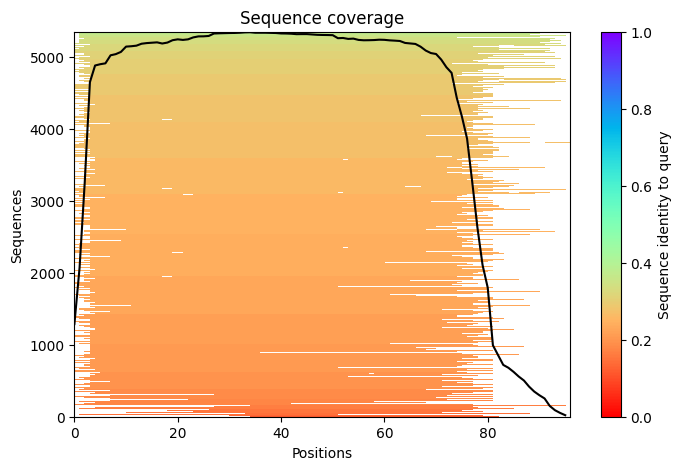

2025-01-02 20:21:08,309 Setting max_seq=512, max_extra_seq=4844


I0000 00:00:1735849276.980114   26352 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


2025-01-02 20:21:43,564 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=89.1 pTM=0.742
2025-01-02 20:21:44,685 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=89.8 pTM=0.758 tol=0.801
2025-01-02 20:21:45,800 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=91.6 pTM=0.782 tol=0.88
2025-01-02 20:21:46,912 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=92 pTM=0.788 tol=0.156
2025-01-02 20:21:46,913 alphafold2_ptm_model_1_seed_000 took 29.5s (3 recycles)


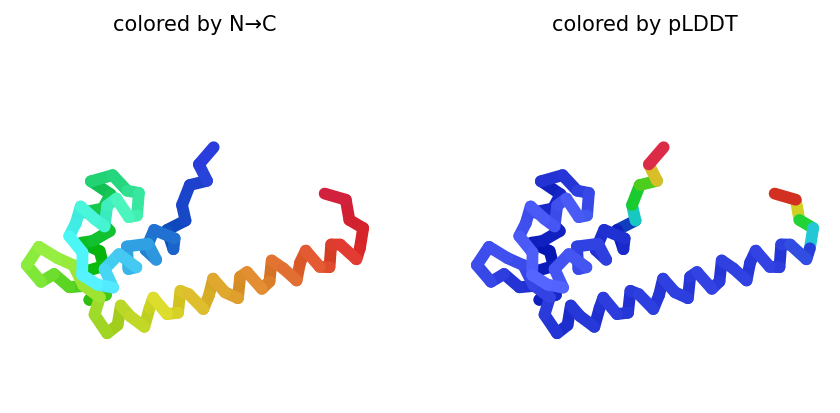

2025-01-02 20:21:48,126 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=86.8 pTM=0.719
2025-01-02 20:21:49,229 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=86.7 pTM=0.715 tol=0.102
2025-01-02 20:21:50,346 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=89.1 pTM=0.749 tol=0.0551
2025-01-02 20:21:51,457 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=89 pTM=0.747 tol=0.0799
2025-01-02 20:21:51,458 alphafold2_ptm_model_2_seed_000 took 4.4s (3 recycles)


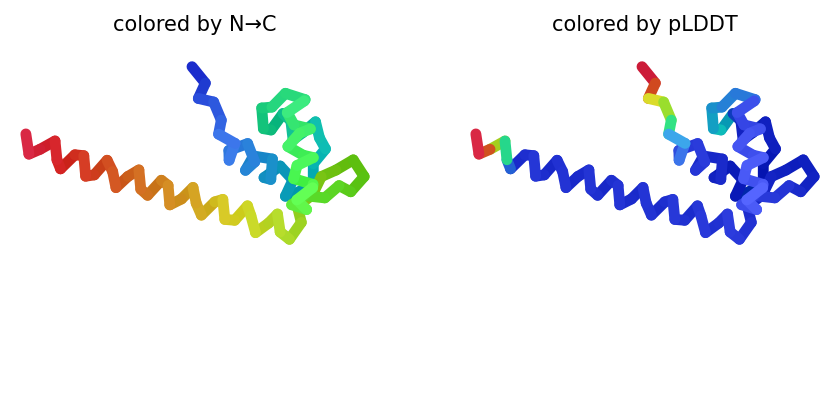

2025-01-02 20:21:52,679 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=91.4 pTM=0.764
2025-01-02 20:21:53,787 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=91.7 pTM=0.768 tol=0.72
2025-01-02 20:21:54,899 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=92 pTM=0.773 tol=0.0916
2025-01-02 20:21:56,010 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=92.6 pTM=0.786 tol=0.0544
2025-01-02 20:21:56,011 alphafold2_ptm_model_3_seed_000 took 4.4s (3 recycles)


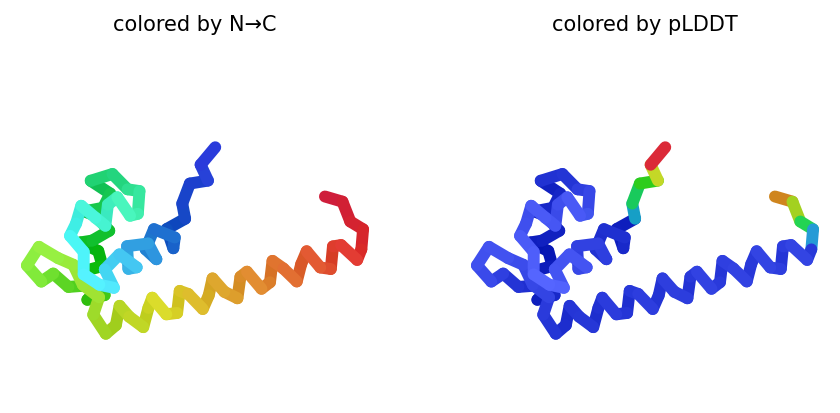

2025-01-02 20:21:57,225 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=91.2 pTM=0.769
2025-01-02 20:21:58,344 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=91.2 pTM=0.773 tol=0.153
2025-01-02 20:21:59,460 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=92 pTM=0.79 tol=0.143
2025-01-02 20:22:00,577 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=92.2 pTM=0.791 tol=0.0631
2025-01-02 20:22:00,578 alphafold2_ptm_model_4_seed_000 took 4.5s (3 recycles)


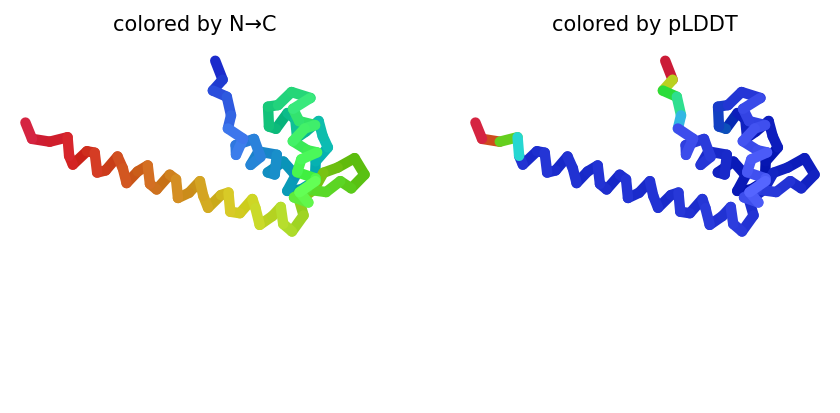

2025-01-02 20:22:01,789 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=89.4 pTM=0.739
2025-01-02 20:22:02,892 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=87.2 pTM=0.701 tol=0.36
2025-01-02 20:22:03,995 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=89 pTM=0.734 tol=0.103
2025-01-02 20:22:05,099 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=89.3 pTM=0.737 tol=0.178
2025-01-02 20:22:05,100 alphafold2_ptm_model_5_seed_000 took 4.4s (3 recycles)


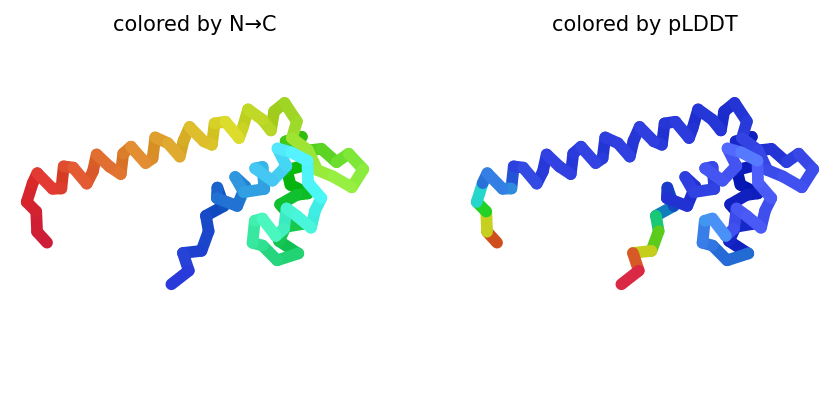

2025-01-02 20:22:05,209 reranking models by 'plddt' metric
2025-01-02 20:22:05,209 rank_001_alphafold2_ptm_model_3_seed_000 pLDDT=92.6 pTM=0.786
2025-01-02 20:22:05,209 rank_002_alphafold2_ptm_model_4_seed_000 pLDDT=92.2 pTM=0.791
2025-01-02 20:22:05,210 rank_003_alphafold2_ptm_model_1_seed_000 pLDDT=92 pTM=0.788
2025-01-02 20:22:05,210 rank_004_alphafold2_ptm_model_5_seed_000 pLDDT=89.3 pTM=0.737
2025-01-02 20:22:05,210 rank_005_alphafold2_ptm_model_2_seed_000 pLDDT=89 pTM=0.747
2025-01-02 20:22:06,194 Done


In [18]:
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=None,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1, 2, 3, 4, 5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
    # use_bfloat16=False,
)

### Define Gradient Function in Jax


In [19]:
# List of tuples, each tuple with the following entries:
# 1. Model name
# 2. Model Instance
# 3. Model Parameters
model_runner_and_params = results["locals"]["model_runner_and_params"]

# Choose the first model for prototyping
model_name, model_runner, model_params = model_runner_and_params[0]
model_runner.params = model_params  # replace with correct parameters

# Get input features for the given protein sequence
feature_dict = results["locals"]["feature_dict"]
input_features = model_runner.process_features(feature_dict, random_seed=0)
r = input_features["aatype"].shape[0]
input_features["asym_id"] = np.tile(feature_dict["asym_id"], r).reshape(r, -1)
single_iter_input_features = jax.tree.map(lambda x: x[0:1], input_features)

In [20]:
# get shapes
aatype = input_features["aatype"]
num_iters = num_recycles + 1
num_ensemble = 1
L = aatype.shape[1]

# initialize


def zeros(shape): return np.zeros(shape, dtype=np.float16)


prev = {
    "prev_msa_first_row": zeros([L, 256]),
    "prev_pair": zeros([L, L, 128]),
    "prev_pos": zeros([L, 37, 3]),
}
key = jax.random.PRNGKey(0)

In [21]:
# Define a wrapping function to calculate the appropriate gradient
exec(
    rf"""
def f_wrap(model_params, key, tree, {", ".join(single_iter_input_features.keys())}, prev):
    args = [{", ".join(single_iter_input_features.keys())}]
    unflattened_tree = jax.tree.unflatten(tree, args)
    return model_runner.apply(model_params, key, {{**unflattened_tree, "prev": prev}})["ranking_confidence"]
    """
)

In [22]:
# Define a wrapping function to calculate the gradient with respect to alpha
exec(
    rf"""
def f_alpha_wrap(alpha, baseline, model_params, key, tree, {", ".join(single_iter_input_features.keys())}, prev):
    args = [{", ".join(single_iter_input_features.keys())}]
    unflattened_tree = jax.tree.unflatten(tree, args)
    unflattened_tree['msa_feat'] = baseline + alpha * (unflattened_tree['msa_feat'] - baseline)
    return model_runner.apply(model_params, key, {{**unflattened_tree, "prev": prev}})["ranking_confidence"]
    """
)

In [23]:
# print name of the input and it's corresponding index to use with jax grad
for idx, name in enumerate(single_iter_input_features.keys()):
    print((idx + 3, name))

(3, 'aatype')
(4, 'asym_id')
(5, 'atom14_atom_exists')
(6, 'atom37_atom_exists')
(7, 'bert_mask')
(8, 'extra_deletion_value')
(9, 'extra_has_deletion')
(10, 'extra_msa')
(11, 'extra_msa_mask')
(12, 'extra_msa_row_mask')
(13, 'is_distillation')
(14, 'msa_feat')
(15, 'msa_mask')
(16, 'msa_row_mask')
(17, 'random_crop_to_size_seed')
(18, 'residue_index')
(19, 'residx_atom14_to_atom37')
(20, 'residx_atom37_to_atom14')
(21, 'seq_length')
(22, 'seq_mask')
(23, 'target_feat')
(24, 'true_msa')


In [24]:
# create the gradient function for the first model
grad_model_runner = jax.grad(f_wrap, argnums=14, allow_int=True)

In [25]:
grad_model_runner_alpha = jax.grad(f_alpha_wrap, allow_int=True)

### IDG Implementation


In [26]:
def IDG(
    single_iter_input_features,
    single_iter_model,
    model_params,
    grad_model_runner,
    N,
    reference="zero",
):
    '''
    Integrated Decision Gradients
    '''
    single_iter_model.config.model.num_recycle = 0
    ig_results, _ = single_iter_model.predict(
        single_iter_input_features, return_representations=True
    )
    if reference.lower() == "zero":
        baseline = jnp.zeros_like(single_iter_input_features["msa_feat"])
    else:
        raise NotImplementedError

    # adaptive sampling
    ad_ig_outputs = []
    ad_ig_input_features = deepcopy(single_iter_input_features)
    for i in tqdm(range(N+1), total=N+1, desc="Adaptive Sampling Gradients"):
        ad_ig_input_features['msa_feat'] = baseline + (
            single_iter_input_features['msa_feat'] - baseline) * i / N
        ad_ig_results, _ = single_iter_model.predict(
            ad_ig_input_features, return_representations=True)
        ad_ig_outputs.append(ad_ig_results['ranking_confidence'])
    diffs = jnp.diff(jnp.array(ad_ig_outputs))
    diffs = (diffs - jnp.min(diffs))/(jnp.max(diffs) - jnp.min(diffs))
    samples_per_bin = jnp.floor(diffs/jnp.sum(diffs) * N)
    num_samples_left = N - int(jnp.sum(samples_per_bin).item())
    sorted_indices = jnp.argsort(samples_per_bin)
    relevant_indices = sorted_indices[:num_samples_left]
    samples_per_bin = samples_per_bin.at[relevant_indices].add(1)

    # IDG computation
    ig_output = np.zeros_like(single_iter_input_features["msa_feat"])
    ig_input_features = deepcopy(single_iter_input_features)
    with tqdm(total=int(jnp.sum(samples_per_bin).item()), desc="IDG"
              ) as pbar:
        for i in range(N):
            for j in range(int(samples_per_bin[i].item())):
                alpha = i/N + j/(N*samples_per_bin[i])
                _, tree = jax.tree.flatten(ig_input_features)
                gradients = grad_model_runner(
                    model_params, key, tree, *
                    [*ig_input_features.values(), prev]
                )
                alpha_gradient = grad_model_runner_alpha(
                    alpha, baseline, model_params, key, tree, *
                    [*single_iter_input_features.values(), prev]
                )
                ig_output += gradients * alpha_gradient
                pbar.update()
    ig_output = ig_output * (
        single_iter_input_features['msa_feat'] - baseline)
    return ig_results, np.squeeze(
        np.asanyarray(ig_output / N))

: 

In [ ]:
ig_results, ig_output = IDG(
    single_iter_input_features,
    model_runner,
    model_params,
    grad_model_runner,
    20,

)

# first index corresponds to input
ig_output_input_seq = ig_output[0]

Adaptive Sampling Gradients:   0%|          | 0/21 [00:00<?, ?it/s]

IDG:   0%|          | 0/20 [00:00<?, ?it/s]

2025-01-02 20:22:49.170954: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3021] Can't reduce memory use below 15.84GiB (17005636867 bytes) by rematerialization; only reduced to 164.86GiB (177020812489 bytes), down from 164.88GiB (177043405693 bytes) originally


In [28]:
ig_importances = np.linalg.norm(ig_output_input_seq, axis=-1)
ig_importances = ig_importances/np.linalg.norm(ig_importances)  # normalize

In [29]:
char2peptide = {
    'C': 'CYS',
    'D': 'ASP',
    'S': 'SER',
    'Q': 'GLN',
    'K': 'LYS',
    'I': 'ILE',
    'P': 'PRO',
    'T': 'THR',
    'F': 'PHE',
    'N': 'ASN',
    'G': 'GLY',
    'H': 'HIS',
    'L': 'LEU',
    'R': 'ARG',
    'W': 'TRP',
    'A': 'ALA',
    'V': 'VAL',
    'E': 'GLU',
    'Y': 'TYR',
    'M': 'MET'
}
labels = [
    f'{char2peptide[b].title()}{a}'
    for (a, b) in enumerate(query_sequence, start=1)
]

### Visualize Integrated Gradients on the Sequence


Text(0.5, 1.0, 'Relative Importances')

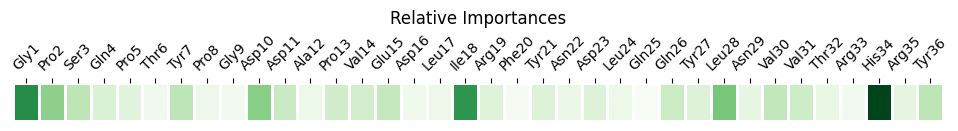

In [ ]:
if protein_name == "Sso10a":
    plt.figure(figsize=(25, 0.5))
else:
    plt.figure(figsize=(12, 0.5))
ax = sns.heatmap(
    np.expand_dims(ig_importances, axis=0), cbar=False, xticklabels=labels,
    yticklabels=[], linewidths=2, cmap="Greens"
)
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
if protein_name == "Sso10a":
    ax.tick_params(axis='x', rotation=60)
else:
    ax.tick_params(axis='x', rotation=45)
ax.set_title("Relative Importances")

## Map Importances to pseudo 3D structure


In [31]:
from alphafold.common import protein
from colabfold.colabfold import plot_pseudo_3D, protein_best_view

In [32]:
final_atom_mask = ig_results["structure_module"]["final_atom_mask"]
b_factors = ig_results["plddt"][:, None] * final_atom_mask
protein_obj = protein.from_prediction(
    features=input_features,
    result=ig_results,
    b_factors=b_factors,
    remove_leading_feature_dimension=("multimer" not in model_type),
)

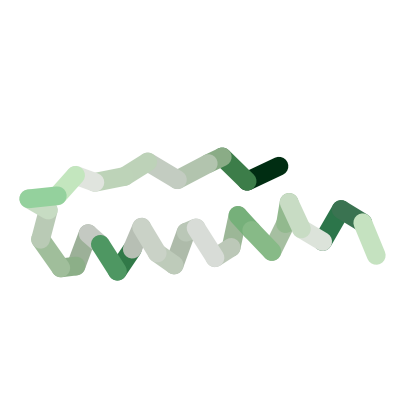

In [33]:
plot_pseudo_3D(
    protein_best_view(protein_obj.atom_positions[:, 1, :]),
    c=np.squeeze(ig_importances),
    cmap="Greens",
)

## Display 3D structure


- Taken directly from the [Colabfold Notebook](https://github.com/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

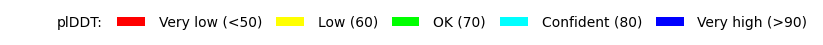

In [34]:
import glob

import py3Dmol
from colabfold.colabfold import (
    alphabet_list,
    pymol_color_list,
    plot_plddt_legend,
)

rank_num = 1  # possible values - ["1", "2", "3", "4", "5"]
color = "lDDT"  # possible values - ["chain", "lDDT", "rainbow"]
show_sidechains = False
show_mainchains = True

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)


def show_pdb(
    rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"
):
    model_name = f"rank_{rank_num}"
    view = py3Dmol.view(
        js="https://3dmol.org/build/3Dmol.js",
    )
    view.addModel(open(pdb_file[0], "r").read(), "pdb")

    if color == "lDDT":
        view.setStyle(
            {
                "cartoon": {
                    "colorscheme": {
                        "prop": "b",
                        "gradient": "roygb",
                        "min": 50,
                        "max": 90,
                    }
                }
            }
        )
    elif color == "rainbow":
        view.setStyle({"cartoon": {"color": "spectrum"}})
    elif color == "chain":
        chains = len(queries[0][1]) + 1 if is_complex else 1
        for n, chain, color in zip(
            range(chains), alphabet_list, pymol_color_list
        ):
            view.setStyle({"chain": chain}, {"cartoon": {"color": color}})

    if show_sidechains:
        BB = ["C", "O", "N"]
        view.addStyle(
            {
                "and": [
                    {"resn": ["GLY", "PRO"], "invert": True},
                    {"atom": BB, "invert": True},
                ]
            },
            {"stick": {"colorscheme": f"WhiteCarbon", "radius": 0.3}},
        )
        view.addStyle(
            {"and": [{"resn": "GLY"}, {"atom": "CA"}]},
            {"sphere": {"colorscheme": f"WhiteCarbon", "radius": 0.3}},
        )
        view.addStyle(
            {"and": [{"resn": "PRO"}, {"atom": ["C", "O"], "invert": True}]},
            {"stick": {"colorscheme": f"WhiteCarbon", "radius": 0.3}},
        )
    if show_mainchains:
        BB = ["C", "O", "N", "CA"]
        view.addStyle(
            {"atom": BB},
            {"stick": {"colorscheme": f"WhiteCarbon", "radius": 0.3}},
        )

    view.zoomTo()
    return view


show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
    plot_plddt_legend().show()

## Map importances to 3D structure


In [35]:
rank_num = 1  # possible values - ["1", "2", "3", "4", "5"]
color = "lDDT"  # possible values - ["chain", "lDDT", "rainbow"]
show_sidechains = False
show_mainchains = True

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

In [36]:
model_name = f"rank_{rank_num}"
view = py3Dmol.view(
    js="https://3dmol.org/build/3Dmol.js",
)
system = open(pdb_file[0], "r").read()
view.addModel(system, "pdb")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [37]:
c = np.squeeze(ig_importances)
c = (c - c.min()) / (c.max() - c.min())
colors = matplotlib.colormaps.get_cmap("Greens")(c)

In [38]:
xyz = protein_obj.atom_positions[:, 1, :]

In [39]:
xyz = np.asarray(xyz)
z = xyz[:, 2]
z = ((z - z.min()) / (z.max() - z.min()))[:, None]
tint, shade = z / 3, (z + 2) / 3
colors = colors + (1 - colors) * tint
colors = colors * shade

In [40]:
i = 0
for line in system.split("\n"):
    if not (line):
        continue
    entries = line.split()
    if entries[0] == "ATOM":
        color = matplotlib.colors.to_hex(colors[int(entries[5]) - 1, :])
        view.setStyle(
            {"model": -1, "serial": i + 1}, {"cartoon": {"color": color}}
        )
        i += 1

In [41]:
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# Correlate IG Importances to Evolutionary Conservation


In [ ]:
ec_df = pd.read_csv(f'ConSurf/{protein_name}.txt', sep='\t', index_col=0)

if protein_name == 'B1':
    ec_df = ec_df.loc[228:282]  # only for B1 domain

ec_df.columns = ec_df.columns.str.strip()
ec_df = ec_df.map(lambda x: x.strip() if type(x) == str else x)
ec_importances = ec_df.COLOR.values.astype(int)
ec_importances = ec_importances/np.linalg.norm(ec_importances)

## Cosine Similarity

- Pearson correlation coefficient is the cosine similarity between centered vectors (i.e. zero mean) - [Link](https://stats.stackexchange.com/questions/235673/is-there-any-relationship-among-cosine-similarity-pearson-correlation-and-z-sc)


In [43]:
# mean normalize the vectors to get negative values in the vectors
dst_similarity_ig = (
    np.dot(ig_importances - ig_importances.mean(),
           ec_importances - ec_importances.mean())
) / (
    np.linalg.norm(ig_importances - ig_importances.mean()) *
    np.linalg.norm(ec_importances - ec_importances.mean())
)

In [44]:
print(f'DST Similarity: {dst_similarity_ig}')

DST Similarity: -0.18353737651935859


## Pearson Correlation Coefficient


In [45]:
pearson_corr = pearsonr(ec_importances, ig_importances)
print(f"Pearson Correlation Coefficient: {pearson_corr.statistic}")

Pearson Correlation Coefficient: -0.18353738462695068


## Spearman Correlation Coefficient


In [46]:
spearman_corr = spearmanr(ec_importances, ig_importances)
print(f"Spearman Correlation Coefficient: {spearman_corr.statistic}")

Spearman Correlation Coefficient: -0.29373121403935765


## Visualize Evolutionary Conservation


Text(0.5, 1.0, 'Evolutionary Conservation')

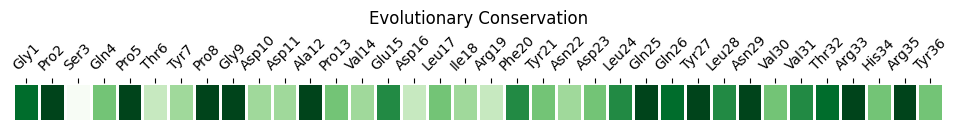

In [47]:
if protein_name == "Sso10a":
    plt.figure(figsize=(25, 0.5))
else:
    plt.figure(figsize=(12, 0.5))
ax = sns.heatmap(
    np.expand_dims(ec_importances, axis=0), cbar=False, xticklabels=labels,
    yticklabels=[], linewidths=2, cmap="Greens"
)
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
if protein_name == "Sso10a":
    ax.tick_params(axis='x', rotation=60)
else:
    ax.tick_params(axis='x', rotation=45)
ax.set_title("Evolutionary Conservation")

## Visualize Functional Residues


Text(0.5, 1.0, 'Functional Residues')

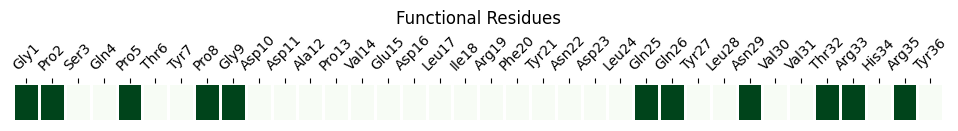

In [48]:
if protein_name == "Sso10a":
    plt.figure(figsize=(25, 0.5))
else:
    plt.figure(figsize=(12, 0.5))
ax = sns.heatmap(
    np.expand_dims((ec_df.loc[:, "F/S"].values == 'f').astype(int), axis=0),
    cbar=False, xticklabels=labels, yticklabels=[], linewidths=2, cmap="Greens"
)
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
if protein_name == "Sso10a":
    ax.tick_params(axis='x', rotation=60)
else:
    ax.tick_params(axis='x', rotation=45)
ax.set_title("Functional Residues")

## Visualize Structural Residues


Text(0.5, 1.0, 'Structural Residues')

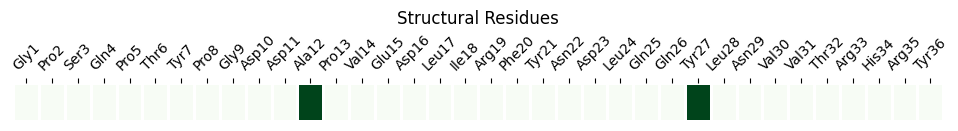

In [49]:
if protein_name == "Sso10a":
    plt.figure(figsize=(25, 0.5))
else:
    plt.figure(figsize=(12, 0.5))
ax = sns.heatmap(
    np.expand_dims((ec_df.loc[:, "F/S"].values == 's').astype(int), axis=0),
    cbar=False, xticklabels=labels, yticklabels=[], linewidths=2, cmap="Greens"
)
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
if protein_name == "Sso10a":
    ax.tick_params(axis='x', rotation=60)
else:
    ax.tick_params(axis='x', rotation=45)
ax.set_title("Structural Residues")